# Simulating the Beam-Weighted Foregroung
#### David W. Barker

## Purpose:
The purpose of this notebook is to create some beam-weighted foregrounds using ULSA for the foreground and Kya's beam models for the beam.

The image below is pretty useful for remembering the frequency range we care about. Image is from Chitta Ranjan Das' ICPPA-2024 talk (International Conference on Particle Physics and Astrophysics)


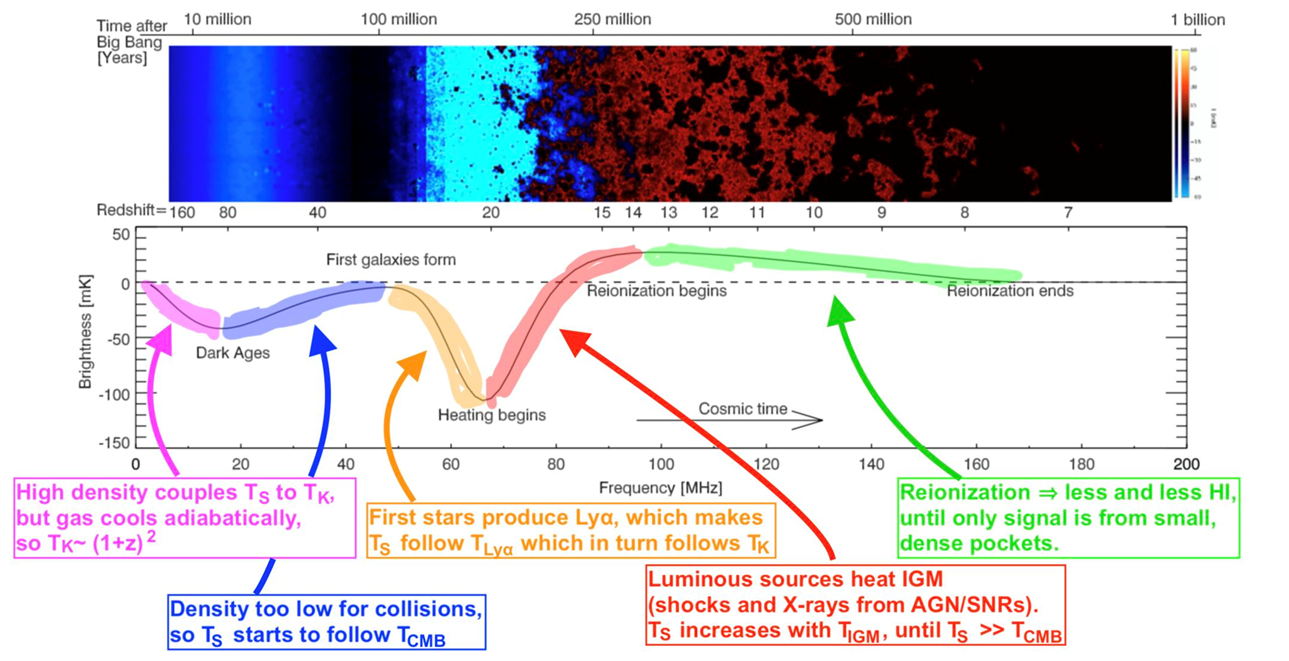

## Beam-weighted Foreground Model:

Let's start with the beam-weighted foreground model.  The beam-weighting, I believe, is as simple as using some function of incident angle of the signal you're recieving and weighting that to the actual simulated signal.  Should look something like this:

$\int_{0}^{\pi}\int_{0}^{2\pi}F(\theta, \nu)B(\theta,\nu)d\theta d\phi$

Where F is your foreground signal and B is your beam weighting. This is the total sky signal for a specific frequency.  Ideally, we would want to graph this as a function of frequency to get our signal, but it depends on where we are pointing our telescope, since the galactic center is not the same as the empty sky.  Our first step is understanding how PERSES deals with this spatial variation.  Is it based on pixels for a total sky map, or do we have to make the conversion ourselves, for example.  Also, does it give you a chance to define the center point that you're pointing at.  I feel like that has to be important if I'm understanding this beam weighting thing at all.  Let's load in a boiler plate and play around with PERSES.

In [1]:
# boiler plate for most pylinex 21-cm stuff

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
import py21cmfast as p21c
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
# boiler plate stuff for healpy
import healpy as hp
from PIL import Image
import matplotlib.animation as animation

In [2]:
# Imporant constants and functions:
NSIDE = 128 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

Prepared Haslam map in 0.127 s.


/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


In [3]:
# Let's now make a function that can convert each point into a pixel number:
# allows us to convert a beam that is a function of angle to a beam as a function of pixel
def ang2pix_interpolator (data,healpy_resolution,normalization = 1):
    """Converts a 3-D beam map into a healpy format (1-D array per frequency, so technically 3-D to 2-D)
    
    Parameters
    =============================================================================================
    data: an interpolation function that takes a 2D array as its argument such as np.array([altitude, azimuth])
    healpy_resolution: the NSIDE resolution your using for the healpy map
    normalization: The number to divide by to normalize the data. Default = 1 (assumes a normalized gain array)
    =============================================================================================
    Returns
    =============================================================================================
    data_healpy_map:  a 2-D array in the shape (frequency, 1-D healpy_map)"""

    # the point is to be able to input any size of beam array and not have to worry about empty spaces due to pixels not being filled it
    # this means we need to fill in the data if it hasn't been provided, which is very easy with an interpolation
    ### Interpolation
    NSIDE = healpy_resolution
    NPIX = 12*NSIDE**2
    thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
    phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
    coordinate_array = np.ones((NPIX,2))
    for i in np.arange(NPIX):
        coordinate_array[i] = np.array([phis[i],thetas[i]])

    data_healpy_map = data(coordinate_array)/normalization

    return data_healpy_map
        
    
    

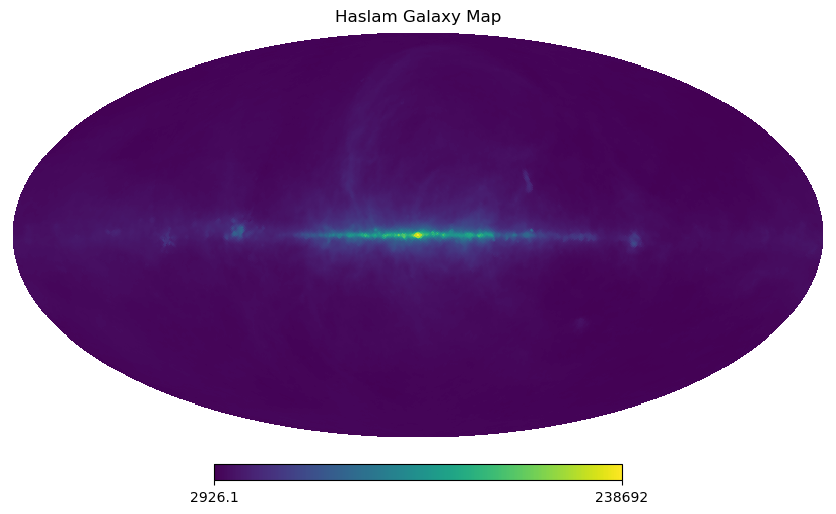

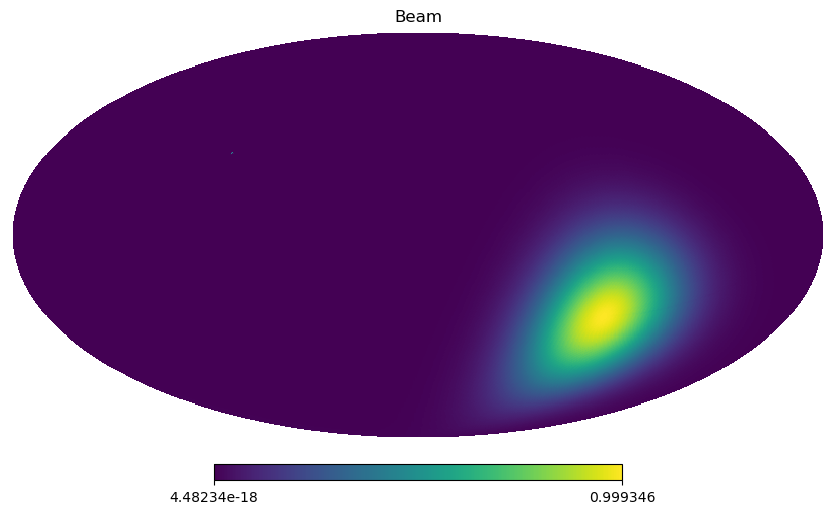

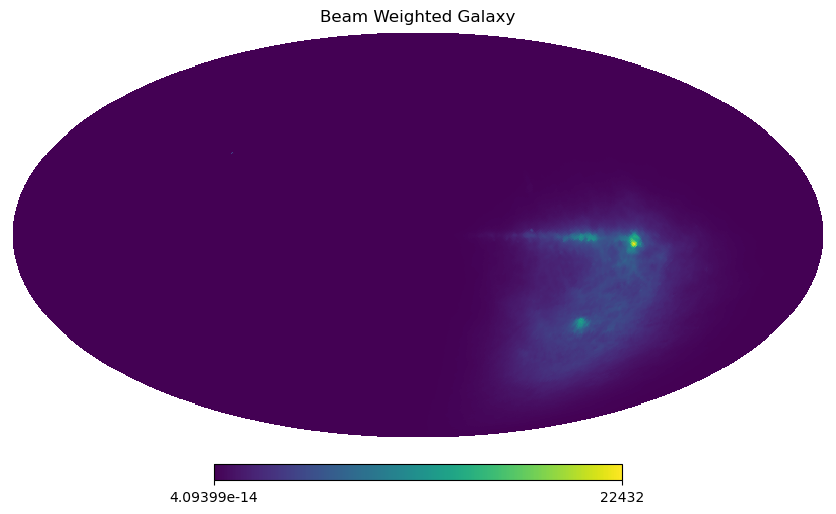

In [46]:
# now let's weight the haslam data with the beam:
hp.mollview(haslam_data,title="Haslam Galaxy Map")
beam_euler_angle = [0,180,60] # this rotates only the beam, not the galaxy
rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(frequency_0_map[0])
hp.mollview(rotated_beam,title="Beam")
visual_euler_angle = [0,0,0]  # this rotates the total map (galaxy times weighted beam)
rotated_haslam = hp.Rotator(rot=visual_euler_angle).rotate_map_pixel(haslam_data*rotated_beam)  # rotates original map m by angle euler_test_angle
hp.mollview(rotated_haslam, title="Beam Weighted Galaxy")  # weighted galaxy with beam


And this is all really cool, but we need to get some actual data out of this.

In [4]:
# Let's pull out the global signal by adding up all of these pixels and getting an average per pixel count.

def beam_weighted_foreground (frequencies,beam,beam_euler_angle=[0,0,0],euler_angle=[0,0,0]):
    """ Returns an array of all of your healpy maps and beam weighted healpy maps per frequency (instead of just one frequency)

    Parameters
    -------------------------------------
    frequencies:  your array of frequencies in which to evaluate over
    beam:     A 2-D array that is N x Pixel count.  The N is your number of evaluated frequencies and must match the haslam_dat_total shape.  This may take some massaging
              (such as with the ang2pix function if you're converting an analytical function to pixel values).
    euler_angle:  3 element array that is your angle of rotation based on a normal galactic plane. Default is no rotation.
    beam_euler_angle:   3 element array that is your angle of rotation based on a normal galactic plane. Default is no rotation.
                        Keep in mind as you rotate the galaxy, this does not automatically follow in the same location (maybe make that automatic later).  
    
    Returns
    -------------------------------------
    haslam_data_total:   2-D array of haslam pixel map values vs your N frequency values (N x Pixel count matrix)
    weighted_foreground_total:    2-D array of the weighted haslam pixel map values vs your N frequency values (N x Pixel count matrix)
    haslam_global:    1-d array of sky averaged global signal intensity vs frequency (get that from the index)"""
    
    gal = perses.foregrounds.HaslamGalaxy()   # generate the Haslam map model through perses
    haslam_data_total = np.zeros((frequencies.shape[0],NPIX))    # make a blank matrix (helpful for later)
    weighted_foreground_total = np.zeros((frequencies.shape[0],NPIX))
    haslam_global_total = np.array([])    # blank array useful for later
    weighted_global_total = np.array([])   # blank array useful for later

    for n,f in enumerate(frequencies):      # goes through all of our frequencies (one of the parameters of the function)
        haslam_data_element=gal.get_map(f) # grabs the healpy array from the haslam model at that specific frequency
        rotated_haslam_element = hp.Rotator(rot=euler_angle).rotate_map_pixel(haslam_data_element)  # rotates original map m by angle euler_test_angle
        haslam_global=rotated_haslam_element.sum()/rotated_haslam.shape[0] # per frequency global signal
        haslam_data_total[n] = haslam_data_element     # add the iterative value of the haslam data to the master array of all the data
        haslam_global_total = np.append(haslam_global_total,haslam_global)      # add the global signal for this frequency to the graph of the global signal
        # for the beam weighted foreground:
        rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(beam[n])     # rotates the beam to whatever location you want to evaluate it at.
        weighted_foreground_total[n] = rotated_haslam_element*rotated_beam   # add the iterative value of the weighted data to the master array of all the weighted data
        weighted_global = (rotated_haslam_element*rotated_beam).sum()/(rotated_haslam*rotated_beam).shape[0]   # per frequency weighted global signal
        weighted_global_total = np.append(weighted_global_total,weighted_global)     # add the weighted global signal for this frequency to the graph of the weighted global signal 
    
    return haslam_data_total, weighted_foreground_total, haslam_global_total, weighted_global_total



In [6]:
# now lets construct a beam profile to plug into the function above:
def make_beam (projected_profile,frequencies,healpy_resolution,d_theta,d_phi):
    """Makes a beam matrix that can be plugged into beam_weighted_foreground
    
    Parameters
    -----------------------------------
    projected_profile:   A 3-D array that maps a 2-D projection of the beam weights onto a theta, phi skymap. The third dimension is frequency.
    frequencies:   Your list of desired frequencies
    healpy_resolution:   Your healpy resolution (usually a factor of 2 like 128 or 64.)
    d_theta:   theta increment used in creating the projected_profile array
    d_phi:   phi increment used in creating the projected_profile array 

    Returns
    ----------------------------------
    beam:   A 2-D array that is N x Pixel count, with N being the number of evaluated frequencies.  
  
    
    """
    beam = np.zeros((frequencies.shape[0],NPIX))     # make a blank matrix (helpful for later)
    for f in range(frequencies.shape[0]):     # iterate through the frequencies
        beam_element = ang2pix(projected_profile,f,healpy_resolution,d_theta,d_phi)    # NOTE: Should probably make a separate function for projecting a beam profile
        beam[f] = beam_element
    return beam


In [16]:
# Let's do some testing: First let's make some beams:
beams=make_beam(projected_profile,frequencies,NSIDE,d_theta,d_phi)

In [17]:
# Now let's plug that in to the beam weighting function:
testing=beam_weighted_foreground(frequencies,beams,[0,10,40])

Prepared Haslam map in 0.113 s.


##### So now we have this testing variable that stores our cool healpy maps per frequency.

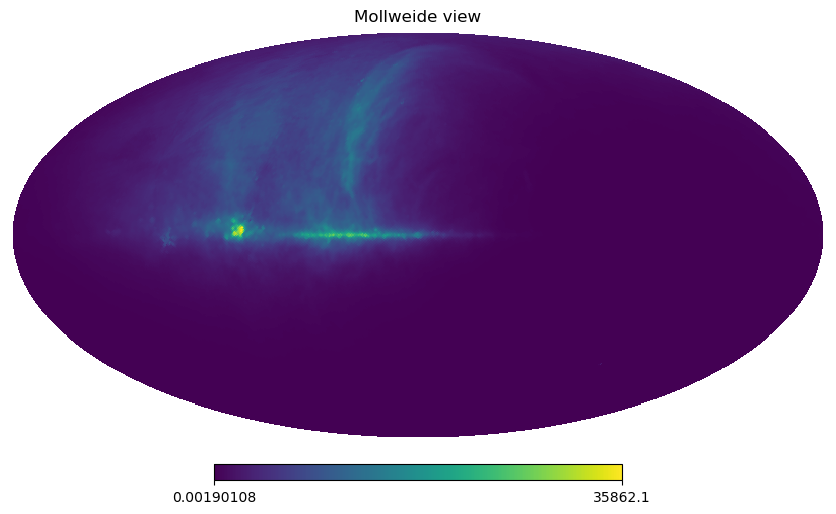

In [18]:
hp.mollview(testing[1][9])

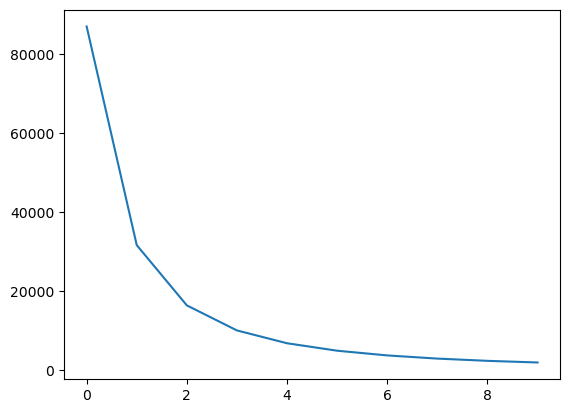

In [19]:
# And here is the kind of plot you'd expect to see for each frequency.  We need to start considering waterfall plots since that is the more common thing in this field
# For now this format is more familiar to me, so I'd like to work with this at first.
plt.plot(testing[3])

## Beam Models from Kaja

Now we need to familiarize ourselves with using Kya's beams.  Keep in mind that in order to interpolate these beams to fill in the gaps that they don't represent, we will need to use the MADEA interpolator written by Joshua.  Let's focus on just understanding the beams first.

Step 1: Let's make the same plots the Fatima made and compare the old models that Kaja had to the new ones.

Here are Fatima's plots:
https://docs.google.com/presentation/d/1sAxtX4HkJDJ0ddXKSibRaiLv3sU3nqPou3ySNn81Go0/edit#slide=id.g3554502c3da_0_6



In [5]:
# Let's make a function that can extract all of the important files from a folder and turn them into a nice array to plot:
# First up is the impedence files:

def kaja_impedence_processing (path_base,path_difference,path_end=False):
    """Converts Kaja's impedence files into an array that can be plotted and/or interpolated to my system.
    Parameters
    ==============================================================================
    path_base: The component of the file path that the files have in common (string)
    path_difference:  The component of the file path that varies (a list of strings, one element for each unique file)
    path_end: If the difference isn't exclusively at the end of the file name, you can use this string to denote an end

    Example: Say you have two files: /home/user1234/project1/example_1_neat.csv
                                     /home/user1234/project1/example_2_neat.csv
    
    path_base would be "/home/user1234/project1/example_"
    path_difference would be ["1","2"]
    path_end would be _"neat.csv"

    Returns
    ==============================================================================
    An array that combines all the desired values"""
    
    
    if path_end:
        total_array = np.genfromtxt(path_base+path_difference[0]+path_end,skip_header=True,delimiter=",")
        for i,j in enumerate(path_difference):
            if i == 0:
                None
            else:
                total_array=np.concatenate((total_array,np.genfromtxt(path_base+j+path_end,skip_header=True,delimiter=",")),axis=0)
            
    else:
        total_array = np.genfromtxt(path_base+path_difference[0]+path_end,skip_header=True,delimiter=",")
        for i,j in enumerate(path_difference):
            if i == 0:
                None
            else:
                total_array=np.concatenate((total_array,np.genfromtxt(path_base+j+path_end,skip_header=True,delimiter=",")),axis=0)
    return total_array




In [6]:
### OLD BEAMS (November 2023)###

# Things the Old Beams all have in common
path_difference_old_impedence = ["01-03","03-06","06-12","12-25","25-50","50-100"]

# The Old Monopole Beams

# Things these impedence files have in common:
path_end_old_impedence_monopole = "MHz_monopole_Phase0deg.csv"

# The comm version (complicated, complex?)
path_base_old_comm_monopole = "/home/dbarker7752/21_cm_group/Kaja_Beams/old_beams/monopole/Impedance/ActiveZParameterPlot_LuSEE_Lander_comm_"
impedence_comm_monopole_Phase0=kaja_impedence_processing(path_base_old_comm_monopole,path_difference_old_impedence,path_end_old_impedence_monopole)

# The comm version simple
path_base_old_simple_monopole = "/home/dbarker7752/21_cm_group/Kaja_Beams/old_beams/monopole/Impedance/ActiveZParameterPlot_LuSEE_Lander_simple_"
impedence_simple_monopole_Phase0=kaja_impedence_processing(path_base_old_simple_monopole,path_difference_old_impedence,path_end_old_impedence_monopole)

# The Old Dipole Beams

# Things these impedence files have in common:
path_end_old_impedence_dipole = "MHz_dipole_Phase180deg.csv"

# The comm version (complicated, complex?)
path_base_old_comm_dipole = "/home/dbarker7752/21_cm_group/Kaja_Beams/old_beams/dipole_180deg/Impedance/ActiveZParameterPlot_LuSEE_Lander_comm_"
impedence_comm_dipole_Phase180=kaja_impedence_processing(path_base_old_comm_dipole,path_difference_old_impedence,path_end_old_impedence_dipole)

# the simple version
path_base_old_simple_dipole = "/home/dbarker7752/21_cm_group/Kaja_Beams/old_beams/dipole_180deg/Impedance/ActiveZParameterPlot_LuSEE_Lander_simple_"
impedence_simple_dipole_Phase180=kaja_impedence_processing(path_base_old_simple_dipole,path_difference_old_impedence,path_end_old_impedence_dipole)

In [ ]:
#### New Beams (April 2025) ####

# Things the New Beams have in common:
path_difference_new_impedence = ["01-03","03-06","06-12","12-25","25-50","50-75"]

## The New Monopole Beams ##

# North #
path_base_new_monopoleN = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_N/ActiveZParameterPlot_02_monopole_N_Phase0deg/ActiveZParameterPlot_02_"
path_end_new_monopoleN = "MHz_monopole_N_Phase0deg.csv"
impedence_monopoleN_Phase0 = kaja_impedence_processing(path_base_new_monopoleN,path_difference_new_impedence,path_end_new_monopoleN)

# East #
path_base_new_monopoleE = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_E/ActiveZParameterPlot_02_monopole_E_Phase0deg/ActiveZParameterPlot_02_"
path_end_new_monopoleE = "MHz_monopole_E_Phase0deg.csv"
impedence_monopoleE_Phase0 = kaja_impedence_processing(path_base_new_monopoleE,path_difference_new_impedence,path_end_new_monopoleE)

# South #
path_base_new_monopoleS = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_S/ActiveZParameterPlot_02_monopole_S_Phase0deg/ActiveZParameterPlot_02_"
path_end_new_monopoleS = "MHz_monopole_S_Phase0deg.csv"
impedence_monopoleS_Phase0 = kaja_impedence_processing(path_base_new_monopoleS,path_difference_new_impedence,path_end_new_monopoleS)

# West #
path_base_new_monopoleW = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_W/ActiveZParameterPlot_02_monopole_W_Phase0deg/ActiveZParameterPlot_02_"
path_end_new_monopoleW = "MHz_monopole_W_Phase0deg.csv"
impedence_monopoleW_Phase0 = kaja_impedence_processing(path_base_new_monopoleW,path_difference_new_impedence,path_end_new_monopoleW)

### New Dipole Beams ##

## Orthogonal Dipoles ##

# E (ES) #
path_base_new_dipoleE_ES = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_ES_Phase180deg/ActiveZParameterPlot_02_dipole_ES_E_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleE_ES = "MHz_dipole_ES_E_Phase180deg.csv"
impedence_dipoleE_ES_Phase180 = kaja_impedence_processing(path_base_new_dipoleE_ES,path_difference_new_impedence,path_end_new_dipoleE_ES)

# S (ES) #
path_base_new_dipoleS_ES = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_ES_Phase180deg/ActiveZParameterPlot_02_dipole_ES_S_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleS_ES = "MHz_dipole_ES_S_Phase180deg.csv"
impedence_dipoleS_ES_Phase180 = kaja_impedence_processing(path_base_new_dipoleS_ES,path_difference_new_impedence,path_end_new_dipoleS_ES)

# N (NE) #
path_base_new_dipoleN_NE = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_NE_Phase180deg/ActiveZParameterPlot_02_dipole_NE_N_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleN_NE = "MHz_dipole_NE_N_Phase180deg.csv"
impedence_dipoleN_NE_Phase180 = kaja_impedence_processing(path_base_new_dipoleN_NE,path_difference_new_impedence,path_end_new_dipoleN_NE)

# E (NE) #
path_base_new_dipoleE_NE = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_NE_Phase180deg/ActiveZParameterPlot_02_dipole_NE_E_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleE_NE = "MHz_dipole_NE_E_Phase180deg.csv"
impedence_dipoleE_NE_Phase180 = kaja_impedence_processing(path_base_new_dipoleE_NE,path_difference_new_impedence,path_end_new_dipoleE_NE)

# S (SW) #
path_base_new_dipoleS_SW = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_SW_Phase180deg/ActiveZParameterPlot_02_dipole_SW_S_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleS_SW = "MHz_dipole_SW_S_Phase180deg.csv"
impedence_dipoleS_SW_Phase180 = kaja_impedence_processing(path_base_new_dipoleS_SW,path_difference_new_impedence,path_end_new_dipoleS_SW)

# W (SW) #
path_base_new_dipoleW_SW = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_SW_Phase180deg/ActiveZParameterPlot_02_dipole_SW_W_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleW_SW = "MHz_dipole_SW_W_Phase180deg.csv"
impedence_dipoleW_SW_Phase180 = kaja_impedence_processing(path_base_new_dipoleW_SW,path_difference_new_impedence,path_end_new_dipoleW_SW)

# W (WN) #
path_base_new_dipoleW_WN = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_WN_Phase180deg/ActiveZParameterPlot_02_dipole_WN_W_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleW_WN = "MHz_dipole_WN_W_Phase180deg.csv"
impedence_dipoleW_WN_Phase180 = kaja_impedence_processing(path_base_new_dipoleW_WN,path_difference_new_impedence,path_end_new_dipoleW_WN)

# N (WN) #
path_base_new_dipoleN_WN = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_WN_Phase180deg/ActiveZParameterPlot_02_dipole_WN_N_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleN_WN = "MHz_dipole_WN_N_Phase180deg.csv"
impedence_dipoleN_WN_Phase180 = kaja_impedence_processing(path_base_new_dipoleN_WN,path_difference_new_impedence,path_end_new_dipoleN_WN)

## Parallel Dipoles

# E (EW) #
path_base_new_dipoleE_EW = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_EW_Phase180deg/ActiveZParameterPlot_02_dipole_EW_E_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleE_EW = "MHz_dipole_EW_Phase180deg.csv"
impedence_dipoleE_EW_Phase180 = kaja_impedence_processing(path_base_new_dipoleE_EW,path_difference_new_impedence,path_end_new_dipoleE_EW)

# W (EW) #
path_base_new_dipoleW_EW = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_EW_Phase180deg/ActiveZParameterPlot_02_dipole_EW_W_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleW_EW = "MHz_dipole_EW_W_Phase180deg.csv"
impedence_dipoleW_EW_Phase180 = kaja_impedence_processing(path_base_new_dipoleW_EW,path_difference_new_impedence,path_end_new_dipoleW_EW)

# N (NS) #
path_base_new_dipoleN_NS = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_NS_Phase180deg/ActiveZParameterPlot_02_dipole_NS_N_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleN_NS = "MHz_dipole_NS_Phase180deg.csv"
impedence_dipoleN_NS_Phase180 = kaja_impedence_processing(path_base_new_dipoleN_NS,path_difference_new_impedence,path_end_new_dipoleN_NS)

# S (NS) #
path_base_new_dipoleS_NS = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_NS_Phase180deg/ActiveZParameterPlot_02_dipole_NS_S_Phase180deg/ActiveZParameterPlot_02_"
path_end_new_dipoleS_NS = "MHz_dipole_NS_S_Phase180deg.csv"
impedence_dipoleS_NS_Phase180 = kaja_impedence_processing(path_base_new_dipoleS_NS,path_difference_new_impedence,path_end_new_dipoleS_NS)

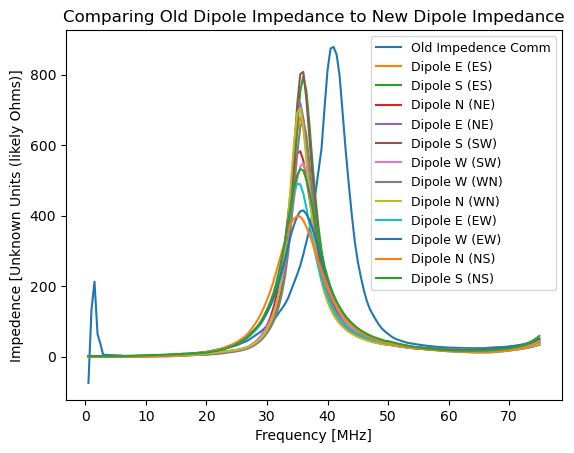

In [9]:
plt.plot(impedence_comm_dipole_Phase180.transpose()[0],impedence_comm_dipole_Phase180.transpose()[1],label="Old Impedence Comm")
#Orthogonal
plt.plot(impedence_dipoleE_ES_Phase180.transpose()[0],impedence_dipoleE_ES_Phase180.transpose()[1],label="Dipole E (ES)")
plt.plot(impedence_dipoleS_ES_Phase180.transpose()[0],impedence_dipoleS_ES_Phase180.transpose()[1],label="Dipole S (ES)")
plt.plot(impedence_dipoleN_NE_Phase180.transpose()[0],impedence_dipoleN_NE_Phase180.transpose()[1],label="Dipole N (NE)")
plt.plot(impedence_dipoleE_NE_Phase180.transpose()[0],impedence_dipoleE_NE_Phase180.transpose()[1],label="Dipole E (NE)")
plt.plot(impedence_dipoleS_SW_Phase180.transpose()[0],impedence_dipoleS_SW_Phase180.transpose()[1],label="Dipole S (SW)")
plt.plot(impedence_dipoleW_SW_Phase180.transpose()[0],impedence_dipoleW_SW_Phase180.transpose()[1],label="Dipole W (SW)")
plt.plot(impedence_dipoleW_WN_Phase180.transpose()[0],impedence_dipoleW_WN_Phase180.transpose()[1],label="Dipole W (WN)")
plt.plot(impedence_dipoleN_WN_Phase180.transpose()[0],impedence_dipoleN_WN_Phase180.transpose()[1],label="Dipole N (WN)")
#Parallel
plt.plot(impedence_dipoleE_EW_Phase180.transpose()[0],impedence_dipoleE_EW_Phase180.transpose()[1],label="Dipole E (EW)")
plt.plot(impedence_dipoleW_EW_Phase180.transpose()[0],impedence_dipoleW_EW_Phase180.transpose()[1],label="Dipole W (EW)")
plt.plot(impedence_dipoleN_NS_Phase180.transpose()[0],impedence_dipoleN_NS_Phase180.transpose()[1],label="Dipole N (NS)")
plt.plot(impedence_dipoleS_NS_Phase180.transpose()[0],impedence_dipoleS_NS_Phase180.transpose()[1],label="Dipole S (NS)")

plt.title("Comparing Old Dipole Impedance to New Dipole Impedance")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Impedence [Unknown Units (likely Ohms)]")
plt.legend(fontsize=9)
plt.savefig("Impedance_Dipole.png")

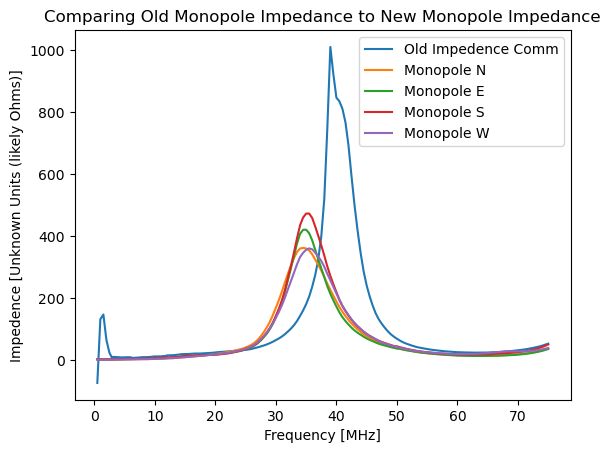

In [8]:
plt.plot(impedence_comm_monopole_Phase0.transpose()[0],impedence_comm_monopole_Phase0.transpose()[1],label="Old Impedence Comm")
#plt.plot(impedence_simple_monopole_Phase0.transpose()[0],impedence_simple_monopole_Phase0.transpose()[1],label="Old Impedence Simple")
plt.plot(impedence_monopoleN_Phase0.transpose()[0],impedence_monopoleN_Phase0.transpose()[1],label="Monopole N")
plt.plot(impedence_monopoleE_Phase0.transpose()[0],impedence_monopoleE_Phase0.transpose()[1],label="Monopole E")
plt.plot(impedence_monopoleS_Phase0.transpose()[0],impedence_monopoleS_Phase0.transpose()[1],label="Monopole S")
plt.plot(impedence_monopoleW_Phase0.transpose()[0],impedence_monopoleW_Phase0.transpose()[1],label="Monopole W")
plt.title("Comparing Old Monopole Impedance to New Monopole Impedance")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Impedence [Unknown Units (likely Ohms)]")
plt.legend()
plt.savefig("Impedance_Monopole")

#### Sky Coverage

Area of a projected sphere:
- $A=d\phi d\theta sin\theta $ steridians
- There are $4\pi$ steridians in a full sphere, so we can get sky coverage using this ratio

Convention with Kaja's files:
- Her convention is odd.  Phi is azimuthal, but it only ranges from 0-180, so its more of a N vs S or E vs W hemisphere demarcation...which is very odd.  Theta is altitude, but it also has negative values for the other hemishphere.

Based on the image below you're integrating over two spheres for the denominator...kinda feels like a type or nonsense, but I'm sure they would have picked up on that.

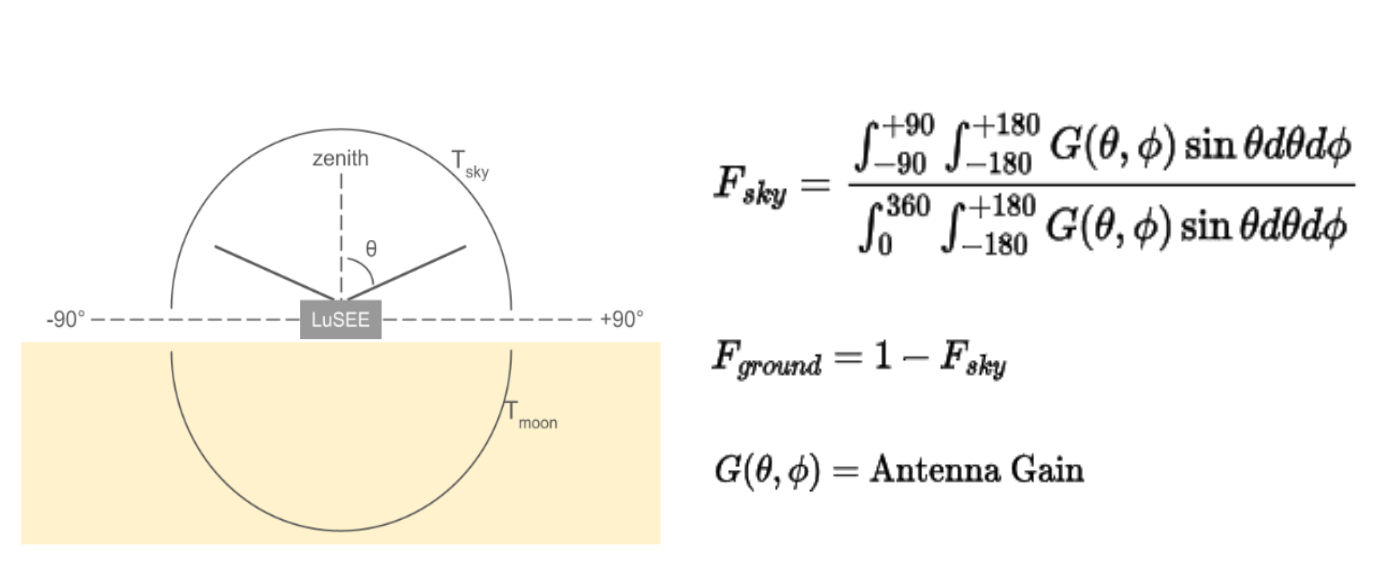

In [7]:
# Let's first read in the data and converting it to a format that makes more sense:

def kaja_beam_processing (file,standard_normalization=True,delta=1):
    """Converts Kaja's beams from her April 2025 release to a format that follows a more typical angle convention. 
    The one used in her files is quite odd and I'd prefer to have the same format for all incoming beam files in the future
    
    Parameters
    =================================================================================
    file: The absolute path of the file to be converted
    standard_normalization: This converts the beams from a steridian based 4pi normalization to a grid based 1 normalization that can be plugged into our healpy maps to properly weight the signal.
    delta: the difference in your grid between thetas and phis in degrees.  Assumes constant and symmetric difference...which probably isn't ideal but it works for what I need for now.
    =================================================================================
    
    Returns
    ==================================================================================
    new_beam:  A new array that follows a more conventional azimuthal, altitude angle approach with 0 degrees being zenith
    old_beam: In case you still want the old one, but now in an array
    beam_function: Interpolation function of new beam"""

    old_beam = np.genfromtxt(file,skip_header=True,delimiter=",") # load in a beam from Kaja's beams
    delete_indexes = np.where(((old_beam[:,0]==0) | (old_beam[:,0] == 180) | (old_beam[:,1] == -180)) & (old_beam[:,1] < 0))[0]
    new_beam = np.delete(old_beam, delete_indexes,axis=0)   # gets rid of the redundant values from Kaja's convention

    for i in np.arange(len(new_beam)):        # loops through and replaces negative thetas with phi's (seriously wierd convention originally)
        if new_beam[i][1] < 0:
            new_beam[i][0] = new_beam[i][0]+180
            new_beam[i][1] = new_beam[i][1]*-1
    
# sky fraction evaluation (isn't as simple as just adding the gains together. The array is a 2D grid projected onto a sphere, so we have to use sin theta dtheta dphi for the area of each point)
    new_beam_mod = np.copy(new_beam)
    for j in np.arange(len(new_beam)):
        new_beam_mod[j][2] = new_beam_mod[j][2]*np.abs(np.sin(new_beam_mod[j][1]*(np.pi/180))*(delta*np.pi/180)**2)  # converts to a 0-1 gain convention per element (1 means all the signal comes through, 0 means none)
    sky_fraction = new_beam_mod.transpose()[2].sum()/(4*np.pi)

# normalize to 1 rather than 4pi
    if standard_normalization:
        for k in np.arange(len(new_beam)):
            new_beam[k][2] = new_beam[k][2]/(4*np.pi)
    

    y = np.array((new_beam.transpose()[0],new_beam.transpose()[1])).transpose()
    d = new_beam[:,2]
    beam_function = scipy.interpolate.RBFInterpolator(y,d,neighbors=10)  # creates a function for the beams using an interpolator.
                                                                        # requires a 2-D array: np.array([phi,theta]) as an input.
    
    return new_beam, old_beam, beam_function, sky_fraction
    



In [9]:
file = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_NS_Phase180deg/GainPlot_02_dipole_NS_Phase180deg/GainPlot_02_20000kHz_dipole_NS_Phase180deg.csv"
test_beam_raw = kaja_beam_processing(file,True)
print(test_beam_raw[0].transpose()[2].sum()/(360*180)*4*np.pi)
print(test_beam_raw[1].transpose()[2].sum()/(360*180))
test_beam_raw[3]

0.5603862765890433
0.5644134750709877


0.4021219563512

In [10]:
def sky_fraction_array (path_base,path_difference,path_end):
    """Calculates the sky fraction for for the range of fequencies of a specific antenna
    ==============================================================================
    path_base: The component of the file path that the files have in common (string)
    path_difference:  The component of the file path that varies (a list of strings, one element for each unique file)
    path_end: If the difference isn't exclusively at the end of the file name, you can use this string to denote an end

    Example: Say you have two files: /home/user1234/project1/example_1_neat.csv
                                     /home/user1234/project1/example_2_neat.csv
    
    path_base would be "/home/user1234/project1/example_"
    path_difference would be ["1","2"]
    path_end would be _"neat.csv"

    Returns
    ==============================================================================
    An array that combines all the desired values"""
    
    
    sky_fraction_array = np.array([])
    for i in range(len(path_difference_array)):
        sky_fraction_array=np.append(sky_fraction_array,kaja_beam_processing(path_base+path_difference[i]+path_end)[3])

    return sky_fraction_array


 


In [11]:
# Handy little shortcut for filling in the path differences

def path_difference (start,end,delta):
    """Creates the path difference array instead of having to do it manually
    Parameters
    ==============================================================================
    start: what number to start at
    end: what number to end at
    delta: the difference between entries
    """
    array = np.arange(start,end+delta,delta)
    list = []
    for i in array:
        if i < 1000:
            list.append("00"+f"{i}")
        elif i <10000:
            list.append("0"+f"{i}")
        else: list.append(f"{i}")
    return list

In [45]:
path_difference_array = path_difference(500,75000,500)

# # Dipole EW phase 180
# pathbase_dipole_EW_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_EW_Phase180deg/GainPlot_02_dipole_EW_Phase180deg/GainPlot_02_"
# pathend_dipole_EW_p180 = "kHz_dipole_EW_Phase180deg.csv"
# skyfrac_dipole_EW_p180 = sky_fraction_array(pathbase_dipole_EW_p180,path_difference_array,pathend_dipole_EW_p180)

# # Dipole NS phase 180
# pathbase_dipole_NS_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_NS_Phase180deg/GainPlot_02_dipole_NS_Phase180deg/GainPlot_02_"
# pathend_dipole_NS_p180 = "kHz_dipole_NS_Phase180deg.csv"
# skyfrac_dipole_NS_p180 = sky_fraction_array(pathbase_dipole_NS_p180,path_difference_array,pathend_dipole_NS_p180)

# # Monopole E
# pathbase_monopole_E = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_E/GainPlot_02_monopole_E_Phase0deg/GainPlot_02_"
# pathend_monopole_E = "kHz_monopole_E_Phase0deg.csv"
# skyfrac_monopole_E = sky_fraction_array(pathbase_monopole_E,path_difference_array,pathend_monopole_E)

# # Monopole N
# pathbase_monopole_N = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_N/GainPlot_02_monopole_N_Phase0deg/GainPlot_02_"
# pathend_monopole_N = "kHz_monopole_N_Phase0deg.csv"
# skyfrac_monopole_N = sky_fraction_array(pathbase_monopole_N,path_difference_array,pathend_monopole_N)

# # Monopole S
# pathbase_monopole_S = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_S/GainPlot_02_monopole_S_Phase0deg/GainPlot_02_"
# pathend_monopole_S = "kHz_monopole_S_Phase0deg.csv"
# skyfrac_monopole_S = sky_fraction_array(pathbase_monopole_S,path_difference_array,pathend_monopole_S)

# # Monopole W
# pathbase_monopole_W = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_W/GainPlot_02_monopole_W_Phase0deg/GainPlot_02_"
# pathend_monopole_W = "kHz_monopole_W_Phase0deg.csv"
# skyfrac_monopole_W = sky_fraction_array(pathbase_monopole_W,path_difference_array,pathend_monopole_W)

# # Orthogonal Dipole ES Phase 180
# pathbase_dipole_ES_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_ES_Phase180deg/GainPlot_02_dipole_ES_Phase180deg/GainPlot_02_"
# pathend_dipole_ES_p180 = "kHz_dipole_ES_Phase180deg.csv"
# skyfrac_dipole_ES_p180 = sky_fraction_array(pathbase_dipole_ES_p180,path_difference_array,pathend_dipole_ES_p180)

# # Orthogonal Dipole NE Phase 180
# pathbase_dipole_NE_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_NE_Phase180deg/GainPlot_02_dipole_NE_Phase180deg/GainPlot_02_"
# pathend_dipole_NE_p180 = "kHz_dipole_NE_Phase180deg.csv"
# skyfrac_dipole_NE_p180 = sky_fraction_array(pathbase_dipole_NE_p180,path_difference_array,pathend_dipole_NE_p180)

# # Orthogonal Dipole SW Phase 180
# pathbase_dipole_SW_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_SW_Phase180deg/GainPlot_02_dipole_SW_Phase180deg/GainPlot_02_"
# pathend_dipole_SW_p180 = "kHz_dipole_SW_Phase180deg.csv"
# skyfrac_dipole_SW_p180 = sky_fraction_array(pathbase_dipole_SW_p180,path_difference_array,pathend_dipole_SW_p180)

# # Orthogonal Dipole WN Phase 180
# pathbase_dipole_WN_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_WN_Phase180deg/GainPlot_02_dipole_WN_Phase180deg/GainPlot_02_"
# pathend_dipole_WN_p180 = "kHz_dipole_WN_Phase180deg.csv"
# skyfrac_dipole_WN_p180 = sky_fraction_array(pathbase_dipole_WN_p180,path_difference_array,pathend_dipole_WN_p180)

# Orthogonal Dipole WN Phase 180
pathbase_dipole_old = "/home/dbarker7752/21_cm_group/Kaja_Beams/old_beams/dipole_180deg/gain/GainPlot_LuSEE_Lander_simple_"
pathend_dipole_old = "kHz_dipole_Phase180deg.csv"
skyfrac_dipole_old = sky_fraction_array(pathbase_dipole_old,path_difference_array,pathend_dipole_old)

In [54]:
skyfrac_dipole_old[150]

IndexError: index 150 is out of bounds for axis 0 with size 150

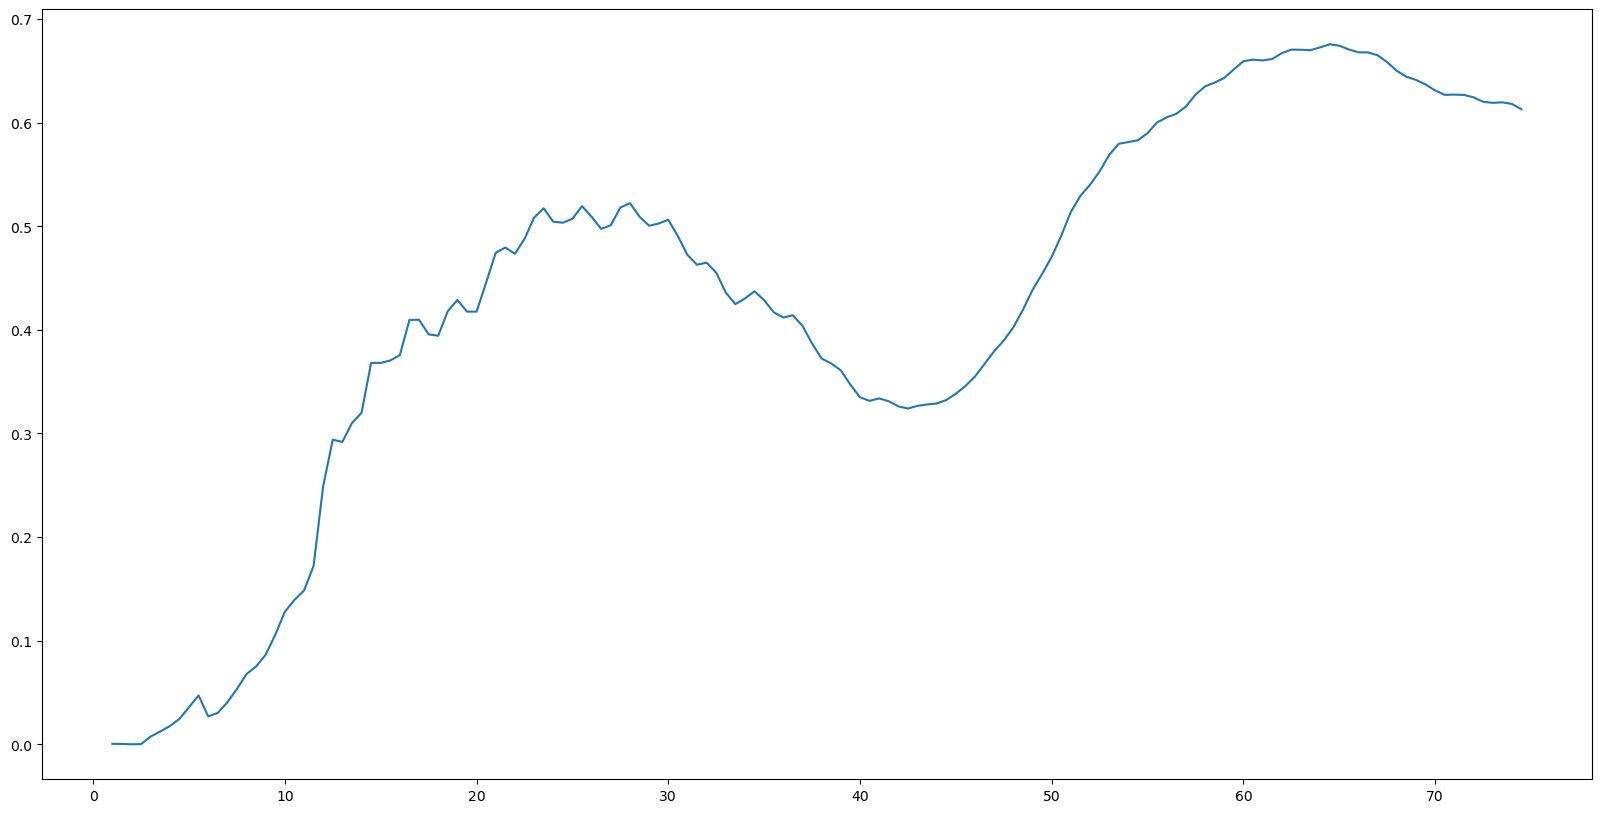

In [56]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
x = np.arange(0.5,75.5,0.5)
plt.plot(x[1:149],skyfrac_dipole_old[1:149],label = "Old Dipole")

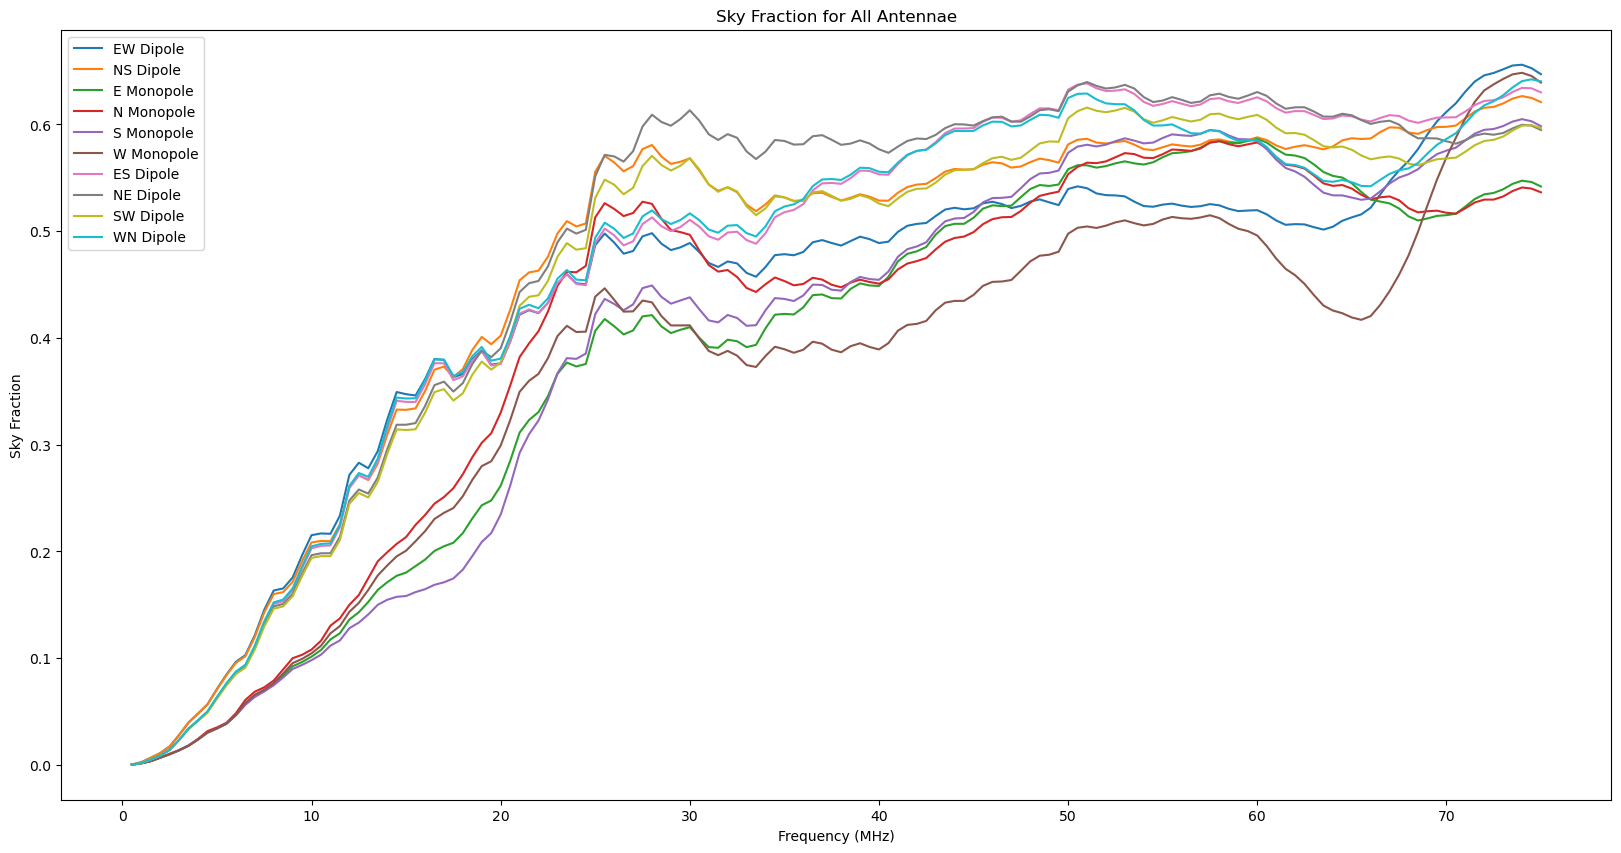

In [ ]:
# Plot the sky fractions
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
x = np.arange(0.5,75.5,0.5)
plt.plot(x,skyfrac_dipole_EW_p180,label = "EW Dipole")
plt.plot(x,skyfrac_dipole_NS_p180,label = "NS Dipole")
plt.plot(x,skyfrac_monopole_E,label = "E Monopole")
plt.plot(x,skyfrac_monopole_N,label = "N Monopole")
plt.plot(x,skyfrac_monopole_S,label = "S Monopole")
plt.plot(x,skyfrac_monopole_W,label = "W Monopole")
plt.plot(x,skyfrac_dipole_ES_p180,label = "ES Dipole")
plt.plot(x,skyfrac_dipole_NE_p180,label = "NE Dipole")
plt.plot(x,skyfrac_dipole_SW_p180,label = "SW Dipole")
plt.plot(x,skyfrac_dipole_WN_p180,label = "WN Dipole")
plt.ylabel("Sky Fraction")
plt.xlabel("Frequency (MHz)")
plt.title("Sky Fraction for All Antennae")
plt.legend()

plt.savefig("Sky Fraction.png")



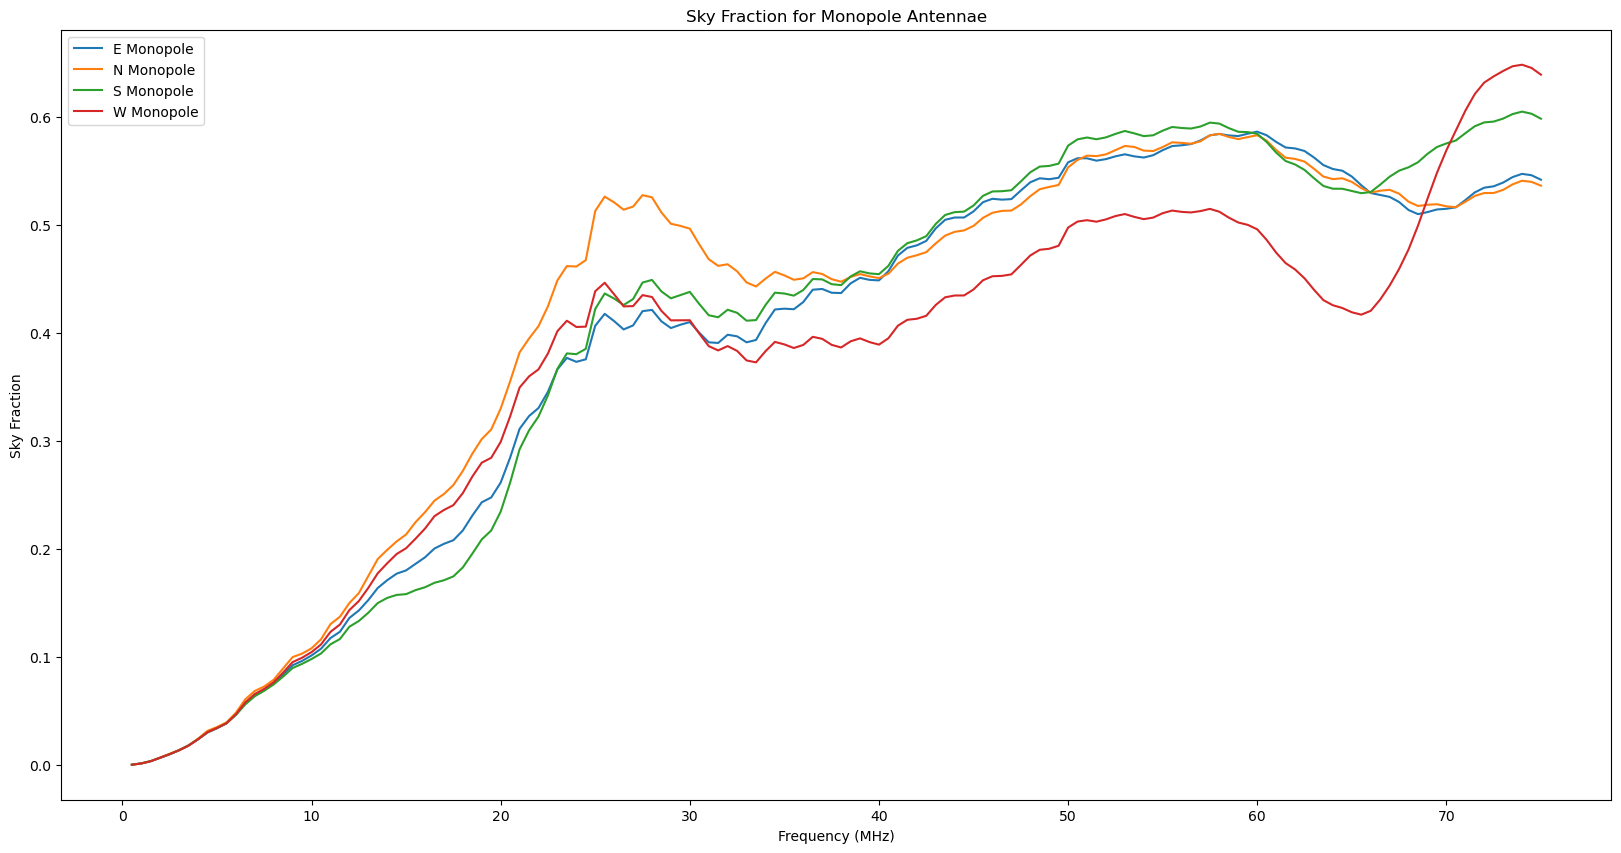

In [186]:
# Plot the sky fractions
x = np.arange(0.5,75.5,0.5)
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.plot(x,skyfrac_monopole_E,label = "E Monopole")
plt.plot(x,skyfrac_monopole_N,label = "N Monopole")
plt.plot(x,skyfrac_monopole_S,label = "S Monopole")
plt.plot(x,skyfrac_monopole_W,label = "W Monopole")

plt.ylabel("Sky Fraction")
plt.xlabel("Frequency (MHz)")
plt.title("Sky Fraction for Monopole Antennae")
plt.legend()
plt.savefig("Sky Fraction Monopoles.png")


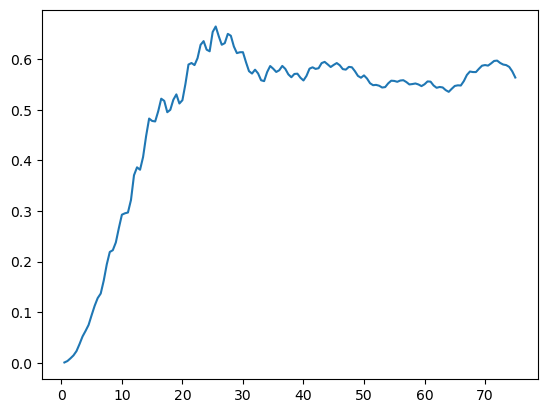

In [131]:
plt.plot(np.arange(0.5,75.5,0.5),sky_fraction_array)

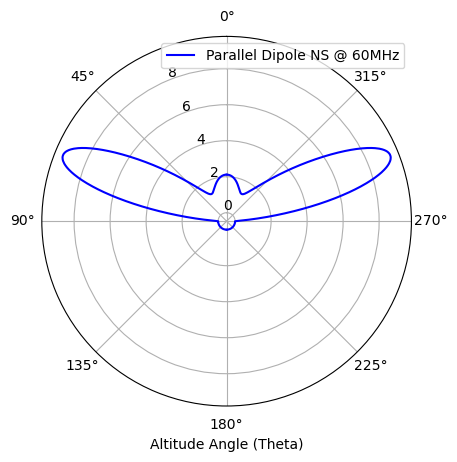

In [10]:
# For comparison between the interpolator and the actual values
n=25776
t = 38376

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set theta = 0 at the top (North)
ax.set_theta_zero_location('N')
#plt.polar(test_beam_raw[0].transpose()[0][n:n+179]*(np.pi/180),test_beam_raw[0].transpose()[2][n:n+179])
#plt.polar(test_beam_raw[0].transpose()[0][t:t+179]*(np.pi/180),test_beam_raw[0].transpose()[2][t:t+179])
theta = np.arange(0,180,0.1)
phi = np.ones_like(theta)*0
plt.polar(theta*(np.pi/180),test_beam_raw[2]((np.array([phi,theta]).transpose())),label="Parallel Dipole NS @ 60MHz",c='blue')
plt.polar(-theta*(np.pi/180),test_beam_raw[2]((np.array([phi,theta]).transpose())),c="blue")
plt.xlabel("Altitude Angle (Theta)")

plt.legend()

#### Now let's see if we can use our beam function to create the correctly formatted beam objects to plug into our earlier code:

In [87]:
test_beam = ang2pix_interpolator(test_beam_raw[2],NSIDE)

<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:3: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_503/206546204.py:3: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")
/tmp/ipykernel_503/206546204.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\ell(\ell+1)C_{\ell}$")


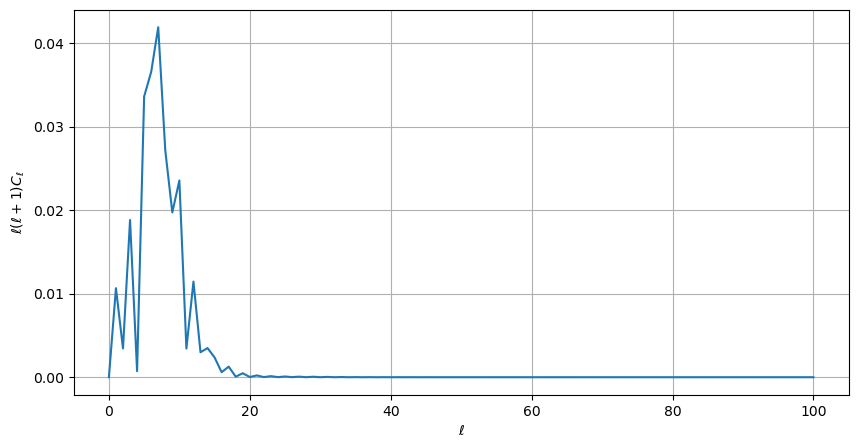

In [ ]:
# The plot of the spherical harmonics calculated abvove
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()

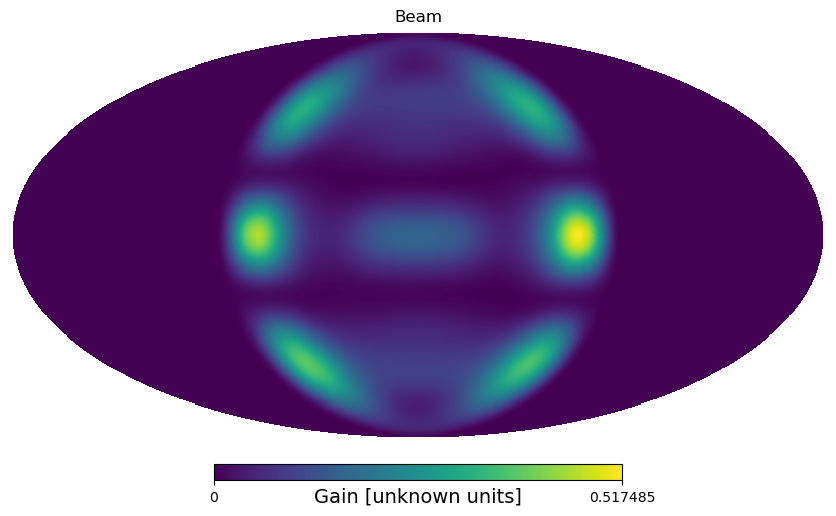

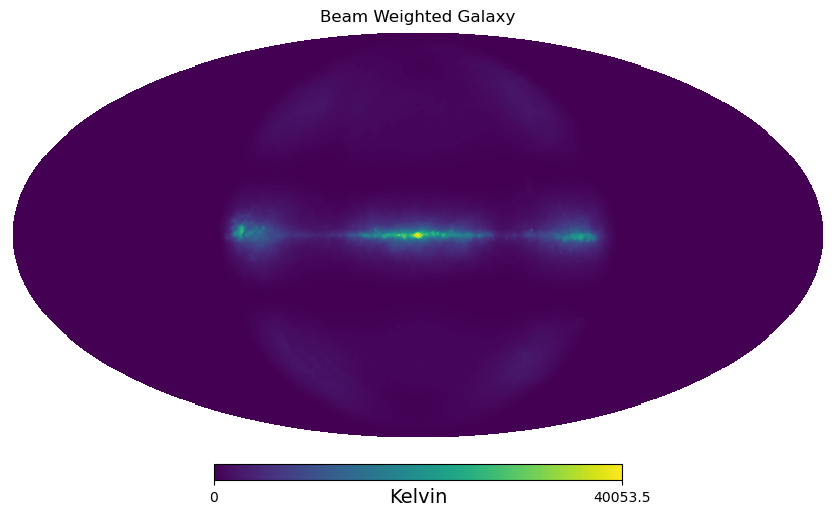

In [90]:
# now let's weight the haslam data with the beam:
# hp.mollview(haslam_data,title="Haslam Galaxy Map")
beam_euler_angle = [0,90,90] # this rotates only the beam, not the galaxy
rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(test_beam)
hp.mollview(rotated_beam,title="Beam",unit="Gain [unknown units]",min=0)
visual_euler_angle = [0,0,0]  # this rotates the total map (galaxy times weighted beam)
rotated_haslam = hp.Rotator(rot=visual_euler_angle).rotate_map_pixel(haslam_data*rotated_beam)  # rotates original map m by angle euler_test_angle
hp.mollview(rotated_haslam, title="Beam Weighted Galaxy",unit="Kelvin",min=0)  # weighted galaxy with beam

#### 

#### Looks like the test beam is successful. Now let's find a good way to be able to move through the various beams visually by saving each of these plots to a folder.

In [12]:
# Let's make a function that collects all of the different frequencies of a sepcific antenna's beam into one variable:
def beam_master_array (path_base,path_difference, path_end,healpy_resolution=NSIDE):
    """Converts Kaja's beam files into a larger 3-D array of beams
    Parameters
    ==============================================================================
    path_base: The component of the file path that the files have in common (string)
    path_difference:  The component of the file path that varies (a list of strings, one element for each unique file)
    path_end: If the difference isn't exclusively at the end of the file name, you can use this string to denote an end

    Example: Say you have two files: /home/user1234/project1/example_1_neat.csv
                                     /home/user1234/project1/example_2_neat.csv
    
    path_base would be "/home/user1234/project1/example_"
    path_difference would be ["1","2"]
    path_end would be _"neat.csv"

    Returns
    ==============================================================================
    An array that combines all the desired values"""
    
    
    if path_end:
        healpy_array = np.array([ang2pix_interpolator(kaja_beam_processing(path_base+path_difference[0]+path_end)[2],healpy_resolution)])
        beam_functions = np.array([kaja_beam_processing(path_base+path_difference[0]+path_end)[2]])
        for i,j in enumerate(path_difference):
            if i == 0:
                None
            else:
                healpy_array=np.concatenate((healpy_array,np.array([ang2pix_interpolator(kaja_beam_processing(path_base+path_difference[i]+path_end)[2],healpy_resolution)])),axis=0) 
                beam_functions = np.concatenate((beam_functions,np.array([kaja_beam_processing(path_base+path_difference[i]+path_end)[2]])),axis=0) 
    else:
        healpy_array = np.array([ang2pix_interpolator(kaja_beam_processing(path_base+path_difference[0])[2],healpy_resolution)])
        beam_functions = np.array([kaja_beam_processing(path_base+path_difference[0])[2]])
        for i,j in enumerate(path_difference):
            if i == 0:
                None
            else:
                healpy_array=np.concatenate((healpy_array,np.array([ang2pix_interpolator(kaja_beam_processing(path_base+path_difference[i])[2],healpy_resolution)])),axis=0)
                beam_functions = np.concatenate((beam_functions,np.array([kaja_beam_processing(path_base+path_difference[i])[2]])),axis=0) 
    return healpy_array, beam_functions, path_difference

In [13]:
# Handy little shortcut for filling in the path differences

def path_difference (start,end,delta):
    """Creates the path difference array instead of having to do it manually
    Parameters
    ==============================================================================
    start: what number to start at
    end: what number to end at
    delta: the difference between entries
    """
    array = np.arange(start,end+delta,delta)
    list = []
    for i in array:
        if i < 1000:
            list.append("00"+f"{i}")
        elif i <10000:
            list.append("0"+f"{i}")
        else: list.append(f"{i}")
    return list



In [57]:
# Let's loop through all the data we've been given and make a beam visualization per frequency:

# ### Uncomment this to create or update your hdf5 files for the beams.  NOTE: this will take around 80 minutes to run ####

path_difference_array = path_difference(500,75000,500)

# # Dipole EW phase 180
# pathbase_dipole_EW_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_EW_Phase180deg/GainPlot_02_dipole_EW_Phase180deg/GainPlot_02_"
# pathend_dipole_EW_p180 = "kHz_dipole_EW_Phase180deg.csv"
# gbeam_dipole_EW_p180 = beam_master_array(pathbase_dipole_EW_p180,path_difference_array,pathend_dipole_EW_p180)

# # Dipole NS phase 180
# pathbase_dipole_NS_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/dipole_NS_Phase180deg/GainPlot_02_dipole_NS_Phase180deg/GainPlot_02_"
# pathend_dipole_NS_p180 = "kHz_dipole_NS_Phase180deg.csv"
# gbeam_dipole_NS_p180 = beam_master_array(pathbase_dipole_NS_p180,path_difference_array,pathend_dipole_NS_p180)

# # Monopole E
# pathbase_monopole_E = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_E/GainPlot_02_monopole_E_Phase0deg/GainPlot_02_"
# pathend_monopole_E = "kHz_monopole_E_Phase0deg.csv"
# gbeam_monopole_E = beam_master_array(pathbase_monopole_E,path_difference_array,pathend_monopole_E)

# # Monopole N
# pathbase_monopole_N = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_N/GainPlot_02_monopole_N_Phase0deg/GainPlot_02_"
# pathend_monopole_N = "kHz_monopole_N_Phase0deg.csv"
# gbeam_monopole_N = beam_master_array(pathbase_monopole_N,path_difference_array,pathend_monopole_N)

# # Monopole S
# pathbase_monopole_S = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_S/GainPlot_02_monopole_S_Phase0deg/GainPlot_02_"
# pathend_monopole_S = "kHz_monopole_S_Phase0deg.csv"
# gbeam_monopole_S = beam_master_array(pathbase_monopole_S,path_difference_array,pathend_monopole_S)

# # Monopole W
# pathbase_monopole_W = "/home/dbarker7752/21_cm_group/Kaja_Beams/monopole_W/GainPlot_02_monopole_W_Phase0deg/GainPlot_02_"
# pathend_monopole_W = "kHz_monopole_W_Phase0deg.csv"
# gbeam_monopole_W = beam_master_array(pathbase_monopole_W,path_difference_array,pathend_monopole_W)

# # Orthogonal Dipole ES Phase 180
# pathbase_dipole_ES_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_ES_Phase180deg/GainPlot_02_dipole_ES_Phase180deg/GainPlot_02_"
# pathend_dipole_ES_p180 = "kHz_dipole_ES_Phase180deg.csv"
# gbeam_dipole_ES_p180 = beam_master_array(pathbase_dipole_ES_p180,path_difference_array,pathend_dipole_ES_p180)

# # Orthogonal Dipole NE Phase 180
# pathbase_dipole_NE_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_NE_Phase180deg/GainPlot_02_dipole_NE_Phase180deg/GainPlot_02_"
# pathend_dipole_NE_p180 = "kHz_dipole_NE_Phase180deg.csv"
# gbeam_dipole_NE_p180 = beam_master_array(pathbase_dipole_NE_p180,path_difference_array,pathend_dipole_NE_p180)

# # Orthogonal Dipole SW Phase 180
# pathbase_dipole_SW_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_SW_Phase180deg/GainPlot_02_dipole_SW_Phase180deg/GainPlot_02_"
# pathend_dipole_SW_p180 = "kHz_dipole_SW_Phase180deg.csv"
# gbeam_dipole_SW_p180 = beam_master_array(pathbase_dipole_SW_p180,path_difference_array,pathend_dipole_SW_p180)

# # Orthogonal Dipole WN Phase 180
# pathbase_dipole_WN_p180 = "/home/dbarker7752/21_cm_group/Kaja_Beams/orthogonal_dipole_WN_Phase180deg/GainPlot_02_dipole_WN_Phase180deg/GainPlot_02_"
# pathend_dipole_WN_p180 = "kHz_dipole_WN_Phase180deg.csv"
# gbeam_dipole_WN_p180 = beam_master_array(pathbase_dipole_WN_p180,path_difference_array,pathend_dipole_WN_p180)

# ### Store as HDF5 Files so we don't have to actually run the above more than once:
f = h5py.File("/home/dbarker7752/21_cm_group/Beam_Plots/Healpy_Beam_Arrays_test","w")
dset01 = f.create_dataset("Dipole EW Phase 180",data=gbeam_dipole_EW_p180[0])
#     dset02 = f.create_dataset("Dipole NS Phase 180",data=gbeam_dipole_NS_p180[0]) 
#     dset03 = f.create_dataset("Monopole E Phase 0",data=gbeam_monopole_E[0])
#     dset04 = f.create_dataset("Monopole N Phase 0",data=gbeam_monopole_N[0])
#     dset05 = f.create_dataset("Monopole S Phase 0",data=gbeam_monopole_S[0])
#     dset06 = f.create_dataset("Monopole W Phase 0",data=gbeam_monopole_W[0])
#     dset07 = f.create_dataset("Dipole ES Phase 180",data=gbeam_dipole_ES_p180[0]) 
#     dset08 = f.create_dataset("Dipole NE Phase 180",data=gbeam_dipole_NE_p180[0])
#     dset09 = f.create_dataset("Dipole SW Phase 180",data=gbeam_dipole_SW_p180[0])
#     dset10 = f.create_dataset("Dipole WN Phase 180",data=gbeam_dipole_WN_p180[0] )






In [58]:
# load up the data within the hdf5 files
f = h5py.File("/home/dbarker7752/21_cm_group/Beam_Plots/Healpy_Beam_Arrays_test","r")
gbeam_dipole_EW_p180_hp = f["Dipole EW Phase 180"]
# gbeam_dipole_NS_p180_hp = f["Dipole NS Phase 180"]
# gbeam_monopole_E_hp = f["Monopole E Phase 0"]
# gbeam_monopole_N_hp = f["Monopole N Phase 0"]
# gbeam_monopole_S_hp = f["Monopole S Phase 0"]
# gbeam_monopole_W_hp = f["Monopole W Phase 0"]
# gbeam_dipole_ES_p180_hp = f["Dipole ES Phase 180"]
# gbeam_dipole_NE_p180_hp = f["Dipole NE Phase 180"]
# gbeam_dipole_SW_p180_hp = f["Dipole SW Phase 180"]
# gbeam_dipole_WN_p180_hp = f["Dipole WN Phase 180"]

In [67]:
f["Dipole EW Phase 180"][2]

array([0.00217168, 0.0021705 , 0.00217131, ..., 0.        , 0.        ,
       0.        ])

In [65]:
gbeam_dipole_EW_p180[0]

array([[0.00014396, 0.00014387, 0.00014393, ..., 0.        , 0.        ,
        0.        ],
       [0.00086812, 0.00086762, 0.00086785, ..., 0.        , 0.        ,
        0.        ],
       [0.00217168, 0.0021705 , 0.00217131, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.11140928, 0.1113874 , 0.11206463, ..., 0.        , 0.        ,
        0.        ],
       [0.10235268, 0.1023726 , 0.10299684, ..., 0.        , 0.        ,
        0.        ],
       [0.09157335, 0.09162518, 0.09222719, ..., 0.        , 0.        ,
        0.        ]])

In [15]:
# needed for the plots
# This code was created using gemini AI (very minor changes)

def animate_images(image_folder, output_path,path_difference_array=path_difference_array, frame_duration=200):
    """
    Animates images in a folder and saves the animation as a GIF.

    Args:
        image_folder (str): Path to the folder containing the images.
        output_path (str): Path to save the output GIF file.
        path_difference_array: the list of differerent file numbers
        frame_duration (int, optional): Duration of each frame in milliseconds. Defaults to 200.
    """
    # image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))],key=int)
    image_files = []
    for i,j in enumerate(path_difference_array):
        image_files.append(image_folder+f"/{int(j)/1000}MHz.png")

    fig, ax = plt.subplots()
    ims = []
    for image_file in image_files:
        img = Image.open(image_file)
        im = ax.imshow(img, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=frame_duration, blit=True, repeat_delay=1000)
    ani.save(output_path, writer='pillow')
    plt.close(fig)

In [16]:
# function for plotting the side plots

def side_plots (beam_master_array,save_location,label,max_value=1,phi=0):
    """Creates the sideplots for a specific master beam
    
    Parameters
    =============================================================================
    beam_master_array:  return of the beam_master_array function
    save_location: location you whish to save these plots (string)
    label: legend label of each plot (first part at least)
    phi: Phi angle to take the slice of (default is 0)
    max_value: The max value that sets the axis limit
    Return
    =============================================================================
    saves the plots to the designated folder and also creates an animation in the same folder"""
    for i,j in enumerate(path_difference_array):
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.set_theta_zero_location('N')
        theta = np.arange(0,180,0.1)
        phi = np.ones_like(theta)*phi
        ax.plot(theta*(np.pi/180),beam_master_array[1][i]((np.array([phi,theta]).transpose())),label=label+f" {int(j)/1000}MHz"+f"@ Phi {phi[0]:.0f}",c='blue')
        ax.plot(-theta*(np.pi/180),beam_master_array[1][i]((np.array([phi,theta]).transpose())),c='blue')
        ax.set_rlim([0,max_value])
        plt.xlabel("Theta")
        plt.legend() 
        plt.savefig(save_location+f"/{int(j)/1000}MHz.png")   # save the plot
        plt.close()
    

    animate_images(save_location,save_location+"Animation.gif",path_difference_array)

    

In [17]:
# for the ploting the sky maps
def sky_plots (healpy_array,save_location,label,max_value=1,phi=0):
    """Creates the sideplots for a specific master beam
    
    Parameters
    =============================================================================
    healpy_array: the healpy array that is to be mapped onto the sky. Should be (Frequency,NPIX) shape (one healpy array per frequency)
    save_location: location you whish to save these plots (string)
    label: legend label of each plot (first part at least)
    phi: Phi angle to take the slice of (default is 0)
    max_value: The max value that sets the axis limit
    Return
    =============================================================================
    saves the plots to the designated folder and also creates an animation in the same folder"""

    # Let's do some plotting
    for i,j in enumerate(path_difference_array):
        beam_euler_angle = [0,90,90] # this rotates only the beam, not the galaxy
        rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(healpy_array[i])
        hp.mollview(rotated_beam,title=label+ f" at {int(j)/1000}MHz",unit="Gain",min=0,max=max_value)
        # visual_euler_angle = [0,0,0]  # this rotates the total map (galaxy times weighted beam)
        # rotated_haslam = hp.Rotator(rot=visual_euler_angle).rotate_map_pixel(haslam_data*rotated_beam)  # rotates original map m by angle euler_test_angle
        # hp.mollview(rotated_haslam, title="Beam Weighted Galaxy",unit="Kelvin",min=0)  # weighted galaxy with beam
        plt.savefig(save_location+f"/{int(j)/1000}MHz.png")
        plt.close()
    
    animate_images(save_location,save_location+"Animation.gif",path_difference_array)
    return

In [18]:

# Dipole EW  Phase 180
side_plots(gbeam_dipole_EW_p180,"/home/dbarker7752/21_cm_group/Beam_Plots/Dipole_EW_Phase180_Side_Plot/Phi0",label=f"Dipole EW",max_value=gbeam_dipole_EW_p180[0].max())
side_plots(gbeam_dipole_EW_p180,"/home/dbarker7752/21_cm_group/Beam_Plots/Dipole_EW_Phase180_Side_Plot/Phi90",label=f"Dipole EW",max_value=gbeam_dipole_EW_p180[0].max(),phi=90)
sky_plots(gbeam_dipole_EW_p180[0],"/home/dbarker7752/21_cm_group/Beam_Plots/Dipole_EW_Phase180_Sky_Plot", label="Dipole EW", max_value = gbeam_dipole_EW_p180[0].max())

In [ ]:
# Monopole E
side_plots(gbeam_monopole_E,"/home/dbarker7752/21_cm_group/LuCEE-Night_Simulation/Beam_weighted_foreground/Beam_Plots/Monopole_E_Side_Plot/Phi0",label=f"Monopole E",max_value=gbeam_monopole_E[0].max())
side_plots(gbeam_monopole_E,"/home/dbarker7752/21_cm_group/LuCEE-Night_Simulation/Beam_weighted_foreground/Beam_Plots/Monopole_E_Side_Plot/Phi90",label=f"Monopole E",max_value=gbeam_monopole_E[0].max(),phi=90)
sky_plots(gbeam_monopole_E[0],"/home/dbarker7752/21_cm_group/LuCEE-Night_Simulation/Beam_weighted_foreground/Beam_Plots/Monopole_E_Sky_Plot", label="Monopole E", max_value = gbeam_monopole_E[0].max()*0.66)

In [37]:
# Dipole EW  Phase 180
#side_plots(gbeam_dipole_WN_p180,"/home/dbarker7752/21_cm_group/Beam_Plots/Dipole_EW_Phase180_Side_Plot/Phi0",label=f"Dipole EW",max_value=gbeam_dipole_WN_p180[0].max())
#side_plots(gbeam_dipole_WN_p180,"/home/dbarker7752/21_cm_group/Beam_Plots/Dipole_EW_Phase180_Side_Plot/Phi90",label=f"Dipole EW",max_value=gbeam_dipole_WN_p180[0].max(),phi=90)
sky_plots(gbeam_dipole_WN_p180_hp,"/home/dbarker7752/21_cm_group/Beam_Plots/Dipole_EW_Phase180_Sky_Plot", label="Dipole EW", max_value = 1)

## Spherical Harmonics
Here's how easy it is to do spherical harmonics in healpy:

In [91]:
test_beam # needs to be any healpy map (ring-ordered, which is always what I do, so that should work)
LMAX = 100
cl = hp.anafast(test_beam, lmax=LMAX)
ell = np.arange(len(cl))

<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:4: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_503/3366605119.py:4: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel("$\ell$")
/tmp/ipykernel_503/3366605119.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.ylabel("$\ell(\ell+1)C_{\ell}$")


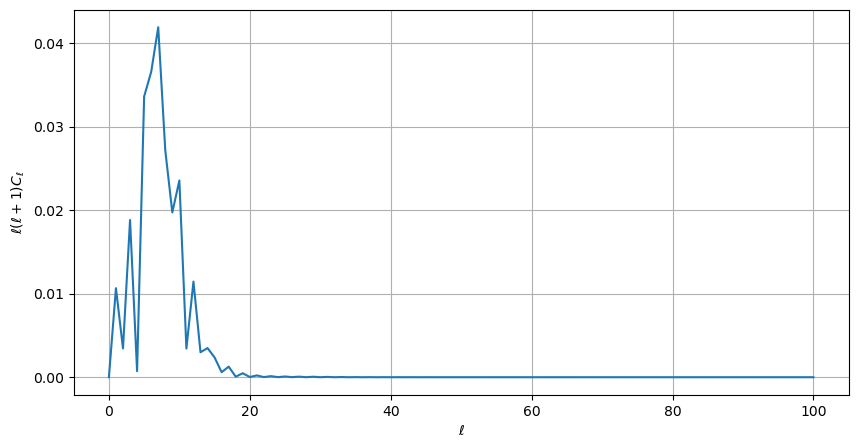

In [92]:
# The plot of the spherical harmonics calculated abvove
plt.figure(figsize=(10, 5))
plt.plot(ell, ell * (ell + 1) * cl)
plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)C_{\ell}$")
plt.grid()

### This is the start of the "Stuff that didn't work / troubleshooting appendix"

All healpy routines assume RING ordering, in fact as soon as you read a map with read_map, even if it was stored as NESTED, it is transformed to RING. However, you can work in NESTED ordering passing the nest=True argument to most healpy routines.

In [16]:
### Stuff that didn't work for the Using the perses.beam.BaseGaussianBeam._GaussianBeam cell ###
# Let's play around with perses.beam.BaseGaussianBeam.GaussianDistribution

# std_function = lambda x: x**2
# std_function_array=np.ones ((num_data_points,num_data_points))
#for i in np.range(0,num_data_points):
   # std_function_array[][]
# gaussian_beam = perses.beam.BaseGaussianBeam.GaussianDistribution(0,10)

# This didn't work because the gaussian profile doesn't separate out each frequency.  Does something odd and a bit nonsensical, actually. Made my own (see above) by canabalizing this one.
#beamarray=GaussianBeam.gaussian_profile(GaussianBeam, frequencies, thetas, phis)   # use this to create an array

In [17]:
# Now let's plot this as a function of theta
plt.plot(thetas,beamarray)

# but what about the frequency dependence?



NameError: name 'beamarray' is not defined

In [ ]:
# Let's see if we can understand why there is no frequency dependence with this function:
exponent = thetas * np.ones_like(phis)
fwhms = np.vectorize(GaussianBeam.fwhm)(frequencies)
exponent = exponent / np.radians(fwhms)
exponent = exponent ** 2
profile = np.exp(-np.log(16) * exponent)

# According to this, the single gaussian profile you get is a bit nonsensical.  It's a gaussian profile evaluated at each angular value, but each angular value has a corresponding, different sigma.
# I see what's attempting to be done here but I also see that it's not working right.  I'm thinking its something to do with vectorize not doing now what it used to do when this was written maybe?
# Just going to right my own beam function canibalizing this one.  Let's see if that's worth the time:

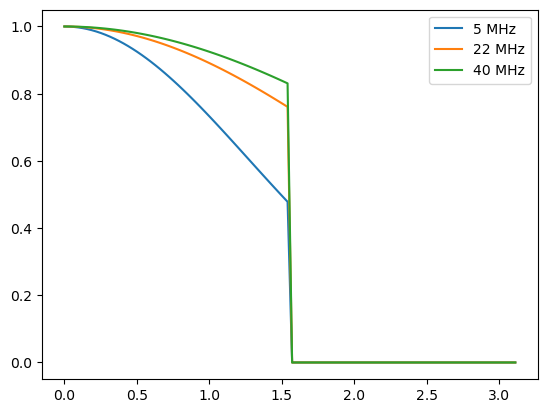

In [ ]:
#Plots three different frequency's gaussian profile
plt.plot(thetas,profile[0], label=f'{frequencies[0]*1e-6:.0f} MHz')
plt.plot(thetas,profile[49], label=f'{frequencies[49]*1e-6:.0f} MHz')
plt.plot(thetas,profile[99], label=f'{frequencies[99]*1e-6:.0f} MHz')
plt.legend()

In [ ]:
import ares

In [ ]:
import ares.simulations


ares.simulations.Global21cm?

Init signature: ares.simulations.Global21cm(**kwargs)
Docstring:     
This class must be inherited by another class, which need only have the
``pf`` attribute.

The three most (only) important parameters are:
    blob_names
    blob_ivars
    blob_funcs
    
Init docstring:
Set up a two-zone model for the global 21-cm signal.

..note :: This is essentially a MultiPhaseMedium calculation, except
    the Lyman alpha background and 21-cm background are calculated,
    and alternative (phenomenological) parameterizations such as a
    tanh for the ionization, thermal, and LW background evolution,
    may be used.
File:           ~/ares/ares/simulations/Global21cm.py
Type:           type
Subclasses:     

In [ ]:
### THIs is the version without the 2d interpolator ###  (Outdated)

# Let's now make a function that can convert each point into a pixel number:
# allows us to convert a beam that is a function of angle to a beam as a function of pixel
def ang2pix (data,healpy_resolution,d_nu,nu_start):
    """Converts a 3-D beam map (2 dimensions for space, 1 dimension for frequency) into a healpy format 
    (1-D array per frequency for the output, so technically 3-D to 2-D)
    
    Parameters
    =============================================================================================
    data: a 3D array of beam weights for 2D positions for each frequency. Shape must be (frequency, altitude, azimuth)
    healpy_resolution: the NSIDE resolution your using for the healpy map
    d_nu: The change in your frequency per index of your data array (hopefully it's uniform)
    nu_start: Starting frequency of index 0
    =============================================================================================
    Returns
    =============================================================================================
    data_healpy_map:  a 2-D array in the shape (frequency, 1-D healpy_map)
    d_nu: Just repeats the d_nu listed in the input so you never lose track of it
    nu_start:  Same as d_nu. May want to move this info into a class later, but we'll see if that's necessary"""

    # the point is to be able to input any size of beam array and not have to worry about empty spaces due to pixels not being filled in
    # this means we need to fill in the data if it hasn't been provided, which is very easy with an interpolation
    
    data_healpy_map = np.zeros((data.shape[0],hp.nside2npix(healpy_resolution)))
    for k in np.arange(data.shape[0]):
        healpy_map = np.zeros(hp.nside2npix(healpy_resolution))
        old_pixel = 0
        pixel_element_array = np.array([])
        for i in np.arange(data.shape[1]):
            for j in np.arange(data.shape[2]):
                pixel_index=hp.ang2pix(healpy_resolution,i*d_theta,j*d_phi)
                if pixel_index == old_pixel:
                    pixel_element_array = np.append(pixel_element_array,data[k][i][j])
                else:
                    healpy_map[pixel_index-1]=np.average(pixel_element_array)
                    old_pixel = pixel_index
                    pixel_element_array = np.array([])
                    pixel_element_array = np.append(pixel_element_array,data[k][i][j])
        data_healpy_map[k] = healpy_map
    return data_healpy_map

### Making a Frequency Dependent Gaussian Beam

In [ ]:
# Using the perses.beam.BaseGaussianBeam._GaussianBeam

num_spatial_data_points = 1000  # specifies the number of data points for the thetas and phis.
num_frequency_data_points = 10  # specifies the number of data points for frequency
# frequency
frequency_start = 5
frequency_end = 40
frequency_increment = np.abs((frequency_start-frequency_end)/num_frequency_data_points)
frequencies = np.arange(frequency_start,frequency_end,frequency_increment)  # frequency in Mhz
# theta
theta_start = 0
theta_end = np.pi
theta_increment = np.abs((theta_start-theta_end)/num_spatial_data_points)
thetas = np.arange(theta_start,theta_end,theta_increment)
# phi
phi_start = 0
phi_end = 2*np.pi
phi_increment = np.abs((phi_start-phi_end)/num_spatial_data_points)
phis = np.arange(phi_start,phi_end,phi_increment)


### Using the perses.beam.BaseGaussianBeam._GaussianBeam ###


GaussianBeam=perses.beam.BaseGaussianBeam._GaussianBeam

# Can adjust whether to use the horizon or not using this property
GaussianBeam.include_horizon=False

# full width half max as a function of frequency x:
GaussianBeam.fwhm = lambda x: (x*1e6)**(1/4)   # right now this is arbitrary and not in any way physical or sensible.  Need to read Joshua's paper to see what he did for the function of the std for the gaussian.
GaussianBeam.initialize_fwhm(GaussianBeam,x_fwhm=GaussianBeam.fwhm) # use this to set the fwhm function

# the cannabalized function taken from perses/perses/beam/BaseGaussianBeam.py gaussian_profile method
fwhms = np.vectorize(GaussianBeam.fwhm)(frequencies)
profile = np.ones((len(frequencies),len(thetas)))
amplitude = 1 # Allows the total gain to be different per frequency (adjusts the gaussian's amplitude [no longer normalized, but that's fine])
for n,x in enumerate(fwhms):   # this is the key difference.  Need to create a 2D array that evaluates each angle at each frequency dependent sigma.
    # this protion is for angular effects of the gaussian distribution
    exponent = thetas * np.ones_like(phis)
    exponent = exponent / np.radians(x)
    exponent = exponent ** 2
    profile_element = amplitude*np.exp(-np.log(16) * exponent)
    if GaussianBeam.include_horizon:
            profile_element = np.where(thetas >= (np.pi / 2), 0, profile_element)
    profile[n] = profile_element

    

In [ ]:
#Plots three different frequency's gaussian profile
plt.plot(thetas,profile[0], label=f'{frequencies[0]:.0f} MHz')
plt.plot(thetas,profile[1], label=f'{frequencies[1]:.0f} MHz')
plt.plot(thetas,profile[5], label=f'{frequencies[5]:.0f} MHz')
plt.legend()

In [ ]:
plt.plot(frequencies,GaussianBeam.fwhm(frequencies))
plt.xlabel(r"$\nu$ (MHz)")
plt.ylabel(r"FWHM (MHz)")

Okay, so we have an analytical function, whos functional form can easily change.  That's all well and good, but what we really care about is being able to map that onto the sky so that we can weight each pixel of the foreground using the corresponding pixel based on this function.  This is where healpy comes in.

FWHM as a function of frequency
Also look at residuals potentially

### Mapping A Guassian Beam Onto the Sky Using healpy

https://healpix.jpl.nasa.gov/pdf/intro.pdf  Useful document for understanding healpy.

In [ ]:
# Let's plug in some numbers for the above function based on our Gaussian:
# NOTE: if it looks funny and kinda like a psychadelic flower, you need a higher spatial resolution 
# in your projected_profile array
frequency_index = 0
frequency_0_map=ang2pix(projected_profile,NSIDE,d_theta,d_phi,0.5,0)
hp.mollview(frequency_0_map[0], title=f"{(frequency_increment*frequency_index)+frequency_start:.2f} MHz")
hp.graticule()
euler_angle = [0,90,0]  # numbers should be in degrees (not radians)
Rotated = hp.Rotator(rot=euler_angle).rotate_map_pixel(frequency_0_map[0])  # rotates original map m by angle euler_test_angle
hp.mollview(Rotated, title=f"{(frequency_increment*frequency_index)+frequency_start:.2f} MHz Top Down View")
hp.graticule()

In [ ]:
# here is our test projection
m = np.arange(NPIX)
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [ ]:
#a key part of this gaussian beam thing is the ability to rotate it to fit the actual set up.
# Let's play with the hp.Rotator method
# convention for the euler angle:
    ### Let's say the equator is the x axis, the meridian the y, and the z axis points out of the screen
    ## First index rotates about the y axis
    ## Second index rotates about the x axis
    ## Third index rotates about the z axis
euler_test_angle = [0,90,0]  # numbers should be in degrees (not radians)
Rotated_test = hp.Rotator(rot=euler_test_angle).rotate_map_pixel(m)  # rotates original map m by angle euler_test_angle
hp.mollview(Rotated_test, title="Rotated Mollview image RING")
hp.graticule()

This is great. It means we can stick to sensible and useful coordinates and then very easily rotate them to new positions in the sky.

Next thing:  Let's actually map that gaussian beam:


In [ ]:
# Let's start by converting angles to pixels to make sure we know what's going on with that:
hp.ang2pix(NSIDE,np.pi/2,np.pi*3/4)
# cool, I think we know what it's doing here
# Now let's convert our Gaussian function into a 2D array of theta and phi:
d_theta = theta_increment  # the increment for each index in theta
d_phi = phi_increment     # the increment for each index in phi
d_freq = frequency_increment  # the increment for each index in frequency
# Let's create a 2D array of the profile values from our Gaussian beam we calculated earlier (frequency,theta,phi)
projected_profile = np.zeros((num_frequency_data_points,thetas.shape[0],thetas.shape[0]))

for i in np.arange(num_frequency_data_points):
    for j in np.arange(thetas.shape[0]):
        for k in np.arange(thetas.shape[0]):
            projected_profile[i][j][0:thetas.shape[0]] = profile[i][j] # because it's an axisymmetric gaussian

# now we have our beam weighting as a function of projected spherical position and frequency  

Next step is to use maybe a Haslam map or something of the sort to see if we can actually weight the thing.